In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
import numpy
import shapey
import splat
import popsims

In [3]:
fig_folder='/users/caganze/research/popsims/figures/'
data_folder='/users/caganze/research/popsims/data/'

In [4]:
AREA=4.4*(u.arcmin**2)*124

In [5]:
H=350
FOV={'jswt': AREA}
#make magnitude cuts
grism_cuts={'JSWT':{ 'NIRISS_F115W':[1, 27.],\
                    'NIRISS_F150W':[1, 27.] }}

#the goods north field
#OINTS={'jswt':SkyCoord(ra="12:36:55", dec="62:14:15", unit=(u.hourangle, u.deg))}
ls= np.concatenate([np.random.uniform(-180, 20, 62), np.random.uniform(20, 180, 62)])
bs= np.concatenate([np.random.uniform(-90, 20, 62), np.random.uniform(20, 90, 62)])
POINTS={'jswt': SkyCoord(l=ls*u.degree, b=bs*u.degree, frame='galactic')}

In [6]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [7]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [8]:
def sample_pointings(scaleH, scaleL, NSAMPLE, volume_kind='exp'):
    ds=[]
    for c in tqdm(POINTS['jswt']):
        p= Pointing(coord=c,density= volume_kind)
        ds.append(p.draw_distances(1, 50000, \
                    scaleH, scaleL, nsample=1e4))
    ds=np.array(ds).flatten()
    return  np.random.choice(ds, int(NSAMPLE), replace=True)

def compute_normalized_volumes(scaleH, scaleL, volume_kind='exp'):
    vs=dict(zip(range(17, 42),np.zeros(len(range(17, 42)))))
    for c in tqdm(POINTS['jswt']):
        p=Pointing(coord=c,density= volume_kind)
        for s in range(17, 42):
            vs[s]+=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                    0, DIST_LIMITS[s],scaleH, scaleL, \
                                   kind= volume_kind)
    
    return  vs

In [9]:
p=Pointing(coord=POINTS['jswt'])
p.mag_limits=grism_cuts['JSWT']
DIST_LIMITS=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [10]:
VOLUMES={'thin_200': compute_normalized_volumes(200,2600, volume_kind='exp'),
         'thin_400':compute_normalized_volumes(400, 2600, volume_kind='exp'),
         'thick':compute_normalized_volumes(900, 3600, volume_kind='exp'),
         'halo': compute_normalized_volumes(900, 3600, volume_kind='spheroid'),
}

100%|████████████████████████████████████████| 124/124 [00:00<00:00, 275.70it/s]


In [11]:
#VOLUMES

In [12]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    scaleH=kwargs.get('h', 350)
    scaleL=kwargs.get('l', 2600)
    kind=kwargs.get('kind', 'exp')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    population=kwargs.get('population', 'thin_disk')
    
    volume_kind=kind
    if kind!='exp':
        volume_kind='spheroid'

    galactic_dists=sample_pointings(scaleH, scaleL, 1e6, volume_kind= volume_kind)
    
    
    dff=create_pop(bfraction=0.2,\
                         model= model,\
                           l=list(POINTS['jswt'].galactic.l.radian),
                           b=list(POINTS['jswt'].galactic.b.radian),
                           absmag_keys=mag_keys, \
                           nsample=int(1e6),
                           distances=galactic_dists,
                  poptype='dwarfs',  population=population)
    
    scale=np.nanmedian(dff.scale)
    
    df_cut= make_cuts(dff,cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    
    #compute volumes
    p= Pointing(coord=POINTS['jswt'][0])
    dct= get_average_distance_limits(p, cuts, survey=survey)
    for spt in tqdm(spgrid):
        sptvol=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., DIST_LIMITS[spt],scaleH, scaleL, \
                           kind= volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [13]:
def get_numbers_by_model(model='burrows1997'):
    thin_number_200=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=200, model=model, population='thin_disk')
    
    thin_number_400=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=400, model=model, population='thin_disk')
    
    thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=900, l=3600, model=model, population='thick_disk')
    
    halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', kind='halo', model=model, population='halo')
    
    return {'thin_200': thin_number_200, 'thin_400': thin_number_400, \
            'thick': thick_number, 'halo': halo_number}

In [14]:
b97=get_numbers_by_model(model='burrows1997')
b01=get_numbers_by_model(model='burrows2001')
b03=get_numbers_by_model(model='baraffe2003')

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 930.89it/s]


In [15]:
import collections
isinstance(list(POINTS['jswt'].galactic.l.radian), collections.Sequence)

True

In [16]:
b01['thick']['data'].keys()

Index(['NIRISS_F115W', 'abs_NIRISS_F115W', 'NIRISS_F150W', 'abs_NIRISS_F150W',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W'],
      dtype='object')

[Text(0.5, 0, 'Log distance (pc)')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


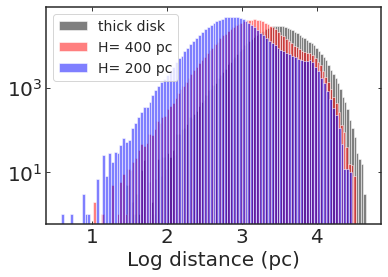

In [17]:
fig, ax=plt.subplots()
_=ax.hist( np.log10(b01['thick']['data']['d']), label='thick disk', color='k', bins=100, alpha=0.5, log=True)
_=ax.hist(  np.log10(b01['thin_400']['data']['d']), label='H= 400 pc', color='r', bins=100, alpha=0.5, log=True)
_=ax.hist(  np.log10(b01['thin_200']['data']['d']), label='H= 200 pc', color='b', bins=100,alpha=0.5,  log=True)
plt.legend(fontsize=14)
ax.set(xlabel='Log distance (pc)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


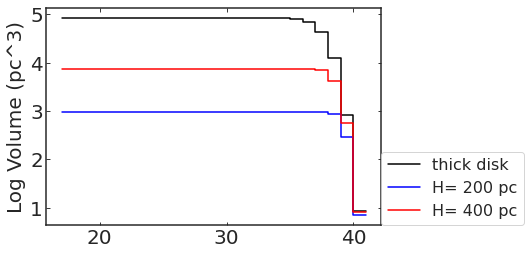

In [18]:
#plot volumes
fig, ax=plt.subplots()
#ax.plot(np.arange(17, 42), b01['halo']['volumes'], label='Halo', c='b')
ax.step(np.arange(17, 42), np.log10(b01['thick']['volumes']), label='thick disk', c='k')
ax.step(np.arange(17, 42), np.log10(b01['thin_200']['volumes']), label='H= 200 pc',c='b')
ax.step(np.arange(17, 42), np.log10(b01['thin_400']['volumes']), label='H= 400 pc',  c='r')
ax.set( ylabel='Log Volume (pc^3)')
ax.legend(fontsize=16, loc=(1, 0))

In [19]:
len(b01['thin_200']['data'])

1136549

In [20]:
def get_scaled_histogram(data, bins):
    scl= data.scale.median()
    counts, edges=np.histogram(data.spt.values, bins=bins)
    return scl*counts

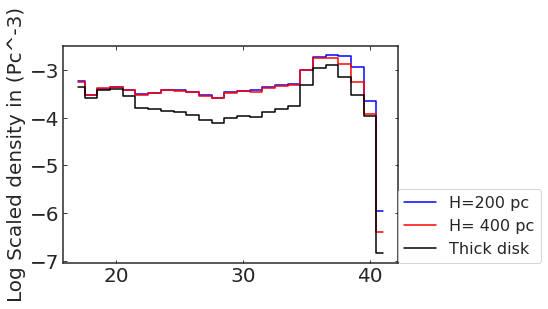

In [21]:

fig, ax=plt.subplots()

ax.step(range(17, 42), np.log10(get_scaled_histogram(b01['thin_200']['data'], 
                                                 bins=range(17, 43))), \
        where='mid',label='H=200 pc', c='b')

ax.step(range(17, 42),  np.log10(get_scaled_histogram(b01['thin_400']['data'], \
                                                                        \
                                              bins=range(17, 43))),  \
        where='mid', label='H= 400 pc', c='r')

ax.step(range(17, 42),  np.log10(get_scaled_histogram(b01['thick']['data'], \
                                                                        \
                                              bins=range(17, 43))),  \
        where='mid', label='Thick disk', c='k')

#ax.step(range(17, 42),  0.0025*(get_scaled_histogram(b01['halo']['data'], \
#                                                                        \
#                                              bins=range(17, 43))), 
#            where='mid',  label='Halo', c='k')

ax.set(ylabel='Log Scaled density in (Pc^-3)')
ax.legend(fontsize=16, loc=(1, 0))

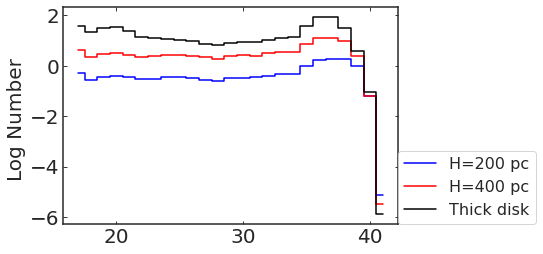

In [22]:
#spectral type distributions
fig, ax=plt.subplots()
ax.step(range(17, 42),  np.log10(b01['thin_200']['volumes']*(get_scaled_histogram(b01['thin_200']['data'], 
                                                 bins=range(17, 43)))),  where='mid', \
        label='H=200 pc', c='b')

ax.step(range(17, 42),  np.log10(b01['thin_400']['volumes']*(get_scaled_histogram(b01['thin_400']['data'], \
                                                        bins=range(17, 43)))),  where='mid',\
        label='H=400 pc', c='r')

ax.step(range(17, 42),  np.log10(b01['thick']['volumes']*(get_scaled_histogram(b01['thick']['data'], \
                                                                         bins=range(17, 43)))),  \
        label='Thick disk', where='mid', c='k')

ax.set(ylabel='Log Number ')
ax.legend(fontsize=16, loc=(1, 0))

In [23]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} ".format(distlimits[x]/1000) for x in locs]

In [24]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))
conversion_area=1/AREA

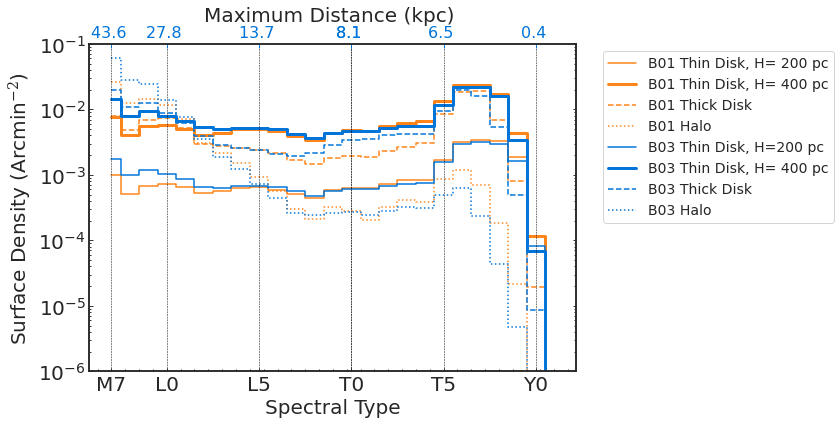

In [50]:
fig, ax=plt.subplots(figsize=(12, 6))


plt.step(np.arange(17, 42), b01['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  label='B01 Thin Disk, H= 200 pc')

plt.step(np.arange(17, 42), b01['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  linewidth=3, label='B01 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b01['thick']['counts']*0.12*conversion_area, \
        where='mid', linestyle='--', color='#FF851B',   label='B01 Thick Disk')

plt.step(np.arange(17, 42), b01['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#FF851B',  label='B01 Halo')


plt.step(np.arange(17, 42), b03['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  label='B03 Thin Disk, H=200 pc')

plt.step(np.arange(17, 42), b03['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  linewidth=3, \
         label='B03 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b03['thick']['counts']*0.12*conversion_area, \
         where='mid', linestyle='--', color='#0074D9', label='B03 Thick Disk')

plt.step(np.arange(17, 42), b03['halo']['counts']*(1/400)*conversion_area,\
         where='mid', linestyle='dotted', color='#0074D9', label='B03 Halo')

#plt.step(np.arange(17, 42), b97['thin_200']['counts']*conversion_area, \
#         where='mid', linestyle='-', color='#0074D9',  label='B97 Thin Disk, H=200 pc')

#plt.step(np.arange(17, 42), b97['thin_400']['counts']*conversion_area, \
#         where='mid', linestyle='-', color='#0074D9',  linewidth=3, label='B97 Thin Disk, H= 400 pc')

#plt.step(np.arange(17, 42), b97['thick']['counts']*0.12*conversion_area, \
#         where='mid', linestyle='--', color='#0074D9', label='B03 Thick Disk')

#plt.step(np.arange(17, 42), b97['halo']['counts']*(1/400)*conversion_area,\
#         where='mid', linestyle='dotted', color='#0074D9', label='B97 Halo')



ax.set(xlabel='Spectral Type', \
       ylabel=r'Surface Density (Arcmin$^{-2}$)', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')
ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([17, 20, 25, 30, 30, 35, 40])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, DIST_LIMITS ), fontsize=16)
ax2.tick_params(colors='#0074D9', which='both') 
ax2.set_xlabel('Maximum Distance (kpc) ')
ax2.grid()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=14)
plt.tight_layout()
#ax.grid( axis='y',  which='major')
ax.minorticks_on()
ax.set_ylim([1e-6, 1e-1])
plt.savefig(fig_folder+'/jswt_counts.pdf', dpi=600)

In [26]:
b03['thin_400']['counts']/b03['thin_200']['counts']

array([8.03272   , 8.04012487, 7.80171965, 7.87451263, 7.81782722,
       8.08390024, 7.86259648, 7.7959514 , 7.83215063, 7.71034587,
       7.5800842 , 7.65947116, 7.59125083, 7.61939465, 7.64374326,
       7.78766969, 7.60682229, 7.50288989, 7.58286313, 7.38786913,
       6.93578461, 5.28144981, 2.15946212, 0.83759087, 0.21687189])

In [27]:
spts= [x for x in np.arange(17, 42)]

In [28]:
#number report
num_rp=pd.DataFrame()
#
num_rp['max_distance']= [round(DIST_LIMITS[x]) for x in np.arange(17, 42)]
num_rp['thin_200_b01']= b01['thin_200']['counts']*conversion_area.value
num_rp['thin_200_b03']= b03['thin_200']['counts']*conversion_area.value
num_rp['thin_200_b97']= b97['thin_200']['counts']*conversion_area.value
num_rp['thin_400_b97']= b97['thin_400']['counts']*conversion_area.value
num_rp['thin_400_b01']= b01['thin_400']['counts']*conversion_area.value
num_rp['thin_400_b03']= b03['thin_400']['counts']*conversion_area.value

num_rp['thick_b01']=b01['thick']['counts']*(0.12)*conversion_area.value
num_rp['thick_b03']=b03['thick']['counts']*(0.12)*conversion_area.value
num_rp['thick_b97']=b97['thick']['counts']*(0.12)*conversion_area.value

num_rp['halo_b03']=b03['halo']['counts']*(1/400)*conversion_area.value
num_rp['halo_b01']=b01['halo']['counts']*(1/400)*conversion_area.value
num_rp['halo_b97']=b97['halo']['counts']*(1/400)*conversion_area.value
num_rp['average']= num_rp[['thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b97']].mean(axis=1)
num_rp.index=spts

for c in num_rp.columns:
    num_rp.loc['total', c]= np.nansum(num_rp[c].loc[spts])
    num_rp.loc['average', c]= np.nanmedian(num_rp[c].loc[spts])

In [29]:
#num_rp

In [30]:
#num_rp=num_rp.applymap(lambda x: np.round(x, 4))

In [31]:
num_rp.columns
#remember to change last column to total

Index(['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_200_b97',
       'thin_400_b97', 'thin_400_b01', 'thin_400_b03', 'thick_b01',
       'thick_b03', 'thick_b97', 'halo_b03', 'halo_b01', 'halo_b97',
       'average'],
      dtype='object')

In [32]:
num_rp[['max_distance', 'thin_200_b03', 'thin_200_b97', 'thin_400_b03',
       'thin_400_b97', 'thick_b03', 'thick_b97', 'halo_b97', 'average']].to_latex('~/desktop/jswt_preds.tex', index=True)

In [52]:
num_rp.loc[17:19].sum()[['thin_200_b01', 'thin_400_b01', 'thin_200_b03',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 6)).values

array([0.002175, 0.017352, 0.003969, 0.031613, 0.01977 , 0.042881,
       0.05308 , 0.113037])

In [53]:
num_rp.loc[20:29].sum()[['thin_200_b01', 'thin_400_b01', 'thin_200_b03',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 6)).values

array([0.00588 , 0.04585 , 0.006777, 0.052831, 0.030223, 0.035909,
       0.028038, 0.029972])

In [54]:
num_rp.loc[30:39].sum()[['thin_200_b01', 'thin_400_b01', 'thin_200_b03',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 6)).values

array([0.017075, 0.110167, 0.015683, 0.100809, 0.065847, 0.070447,
       0.004546, 0.002825])

In [55]:
num_rp.loc[40:41].sum()[['thin_200_b01', 'thin_400_b01', 'thin_200_b03',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 6)).values

array([1.16e-04, 1.18e-04, 8.30e-05, 7.00e-05, 2.00e-05, 9.00e-06,
       0.00e+00, 0.00e+00])

In [57]:
num_rp.loc['total'][['thin_200_b01', 'thin_400_b01', 'thin_200_b03',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 6)).values

array([0.025246, 0.173488, 0.026513, 0.185323, 0.115861, 0.149245,
       0.085664, 0.145834])

In [38]:
num_rp.loc['total']*(AREA/124)

max_distance    1.462080e+06
thin_200_b01    1.110819e-01
thin_200_b03    1.166555e-01
thin_200_b97    1.106120e-01
thin_400_b97    7.594625e-01
thin_400_b01    7.633461e-01
thin_400_b03    8.154230e-01
thick_b01       5.097877e-01
thick_b03       6.566790e-01
thick_b97       4.628162e-01
halo_b03        6.416691e-01
halo_b01        3.769228e-01
halo_b97        3.394325e-01
average         4.732008e-01
Name: total, dtype: float64

[Text(0.5, 9.5, 'Age (Gyr)')]

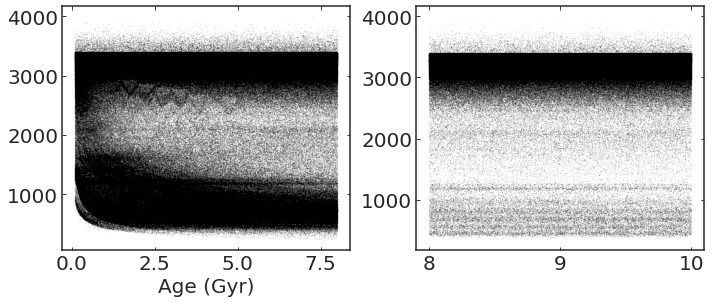

In [39]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4))
_=ax.scatter( b97['thin_200']['data']['age'],  b97['thin_200']['data']['temperature'], \
             label='thick disk', color='k', s=0.1, alpha=0.1)

_=ax1.scatter( b97['halo']['data']['age'],  b97['halo']['data']['temperature'], \
             label='halo', color='k', s=0.1, alpha=0.1)


plt.tight_layout()
ax.set(xlabel='Age (Gyr)')

In [7]:
import numpy as np
int(np.random.uniform(0, 10000))

1237

In [10]:
f'{int(np.random.uniform(0, 10000)):05}'

'02670'